In [1]:
import os

os.environ["OMP_NUM_THREADS"] = "4"

import pickle
from s2and.data import ANDData
from s2and.eval import cluster_eval
import numpy as np
from numpy.linalg import norm

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context='talk')

data_original = "/net/nfs2.s2-research/phantasm/S2AND/s2and_mini/"

specter_suffixes = ["_specter2_def.pkl", "_specter2.pkl"] #"_specter.pickle"]

random_seed = 42
n_jobs = 4

# aminer has too much variance
# medline is pairwise only
datasets = [
    "arnetminer",
    "inspire",
    "kisti",
    "pubmed",
    "qian",
    "zbmath",
]

# this is the prod 1.1 model
with open("../data/model_dump.pickle", "rb") as f:
    clusterer = pickle.load(f)["clusterer"]
    clusterer.use_cache = False  # very important


RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xd

KeyboardInterrupt: 

In [9]:
dataset_name = 'qian'
with open(os.path.join(data_original, dataset_name, dataset_name + specter_suffixes[0]), "rb") as _pickle_file:
    X2, keys2 = pickle.load(_pickle_file)

with open(os.path.join(data_original, dataset_name, dataset_name + specter_suffixes[1]), "rb") as _pickle_file:
    X1, keys1 = pickle.load(_pickle_file)

# subset X2 to just the ones in X1 for a more direct comparison
flag = np.array([i in keys1 for i in keys2])
X2 = X2[flag]
keys2 = keys2[flag]

# make sure X1 and X2 are in the same order
keys1 = list(keys1)
X1 = np.array([X1[keys1.index(i)] for i in keys2])

In [10]:
X1 = X1[:1000, :]
X2 = X2[:1000, :]

Text(0, 0.5, 'specter 2 vector norms for qian')

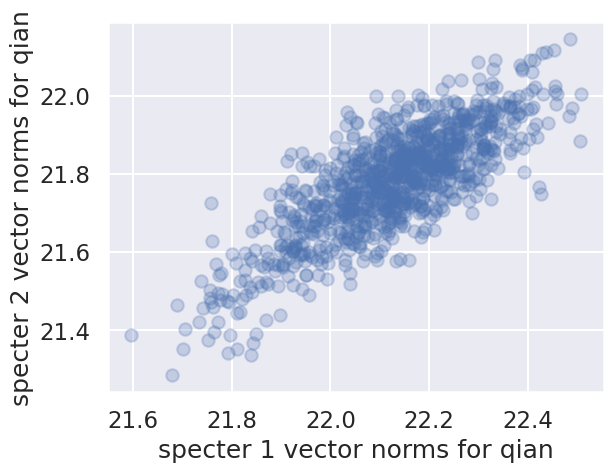

In [11]:
plt.scatter(norm(X1, axis=1), norm(X2, axis=1), alpha=0.25)
plt.xlabel('specter 1 vector norms for qian')
plt.ylabel('specter 2 vector norms for qian')

In [12]:
# plot all pairs of cosine similarities for both and scatter those against each other
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim_1 = cosine_similarity(X1)
cosine_sim_2 = cosine_similarity(X2)

In [13]:
cosine_sim_2.min()

0.6744513

[[1.         0.89946382]
 [0.89946382 1.        ]]


Text(0, 0.5, 'specter 2 cosine similarities for qian')

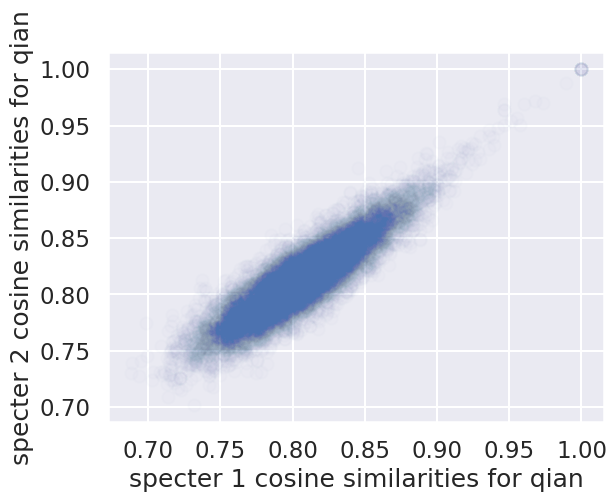

In [15]:
# pick a random 10000 elements from these and scatter them
random_elements = np.random.choice(np.arange(len(cosine_sim_1)**2), size=10000, replace=False)
elements_1 = cosine_sim_1.flatten()[random_elements]
elements_2 = cosine_sim_2.flatten()[random_elements]

# what is the correlation between them?
print(np.corrcoef(elements_1, elements_2))

plt.scatter(elements_1, elements_2, alpha=0.01)
plt.xlabel('specter 1 cosine similarities for qian')
plt.ylabel('specter 2 cosine similarities for qian')

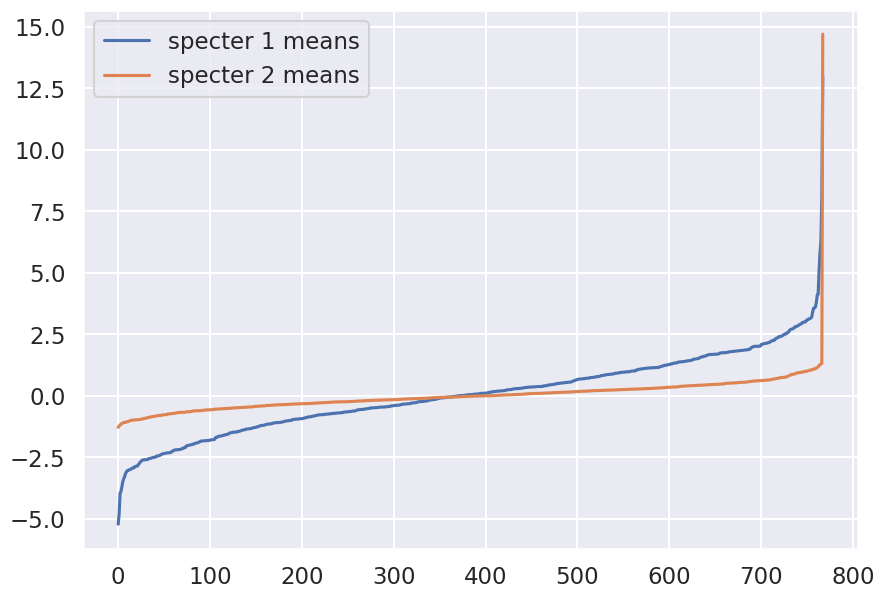

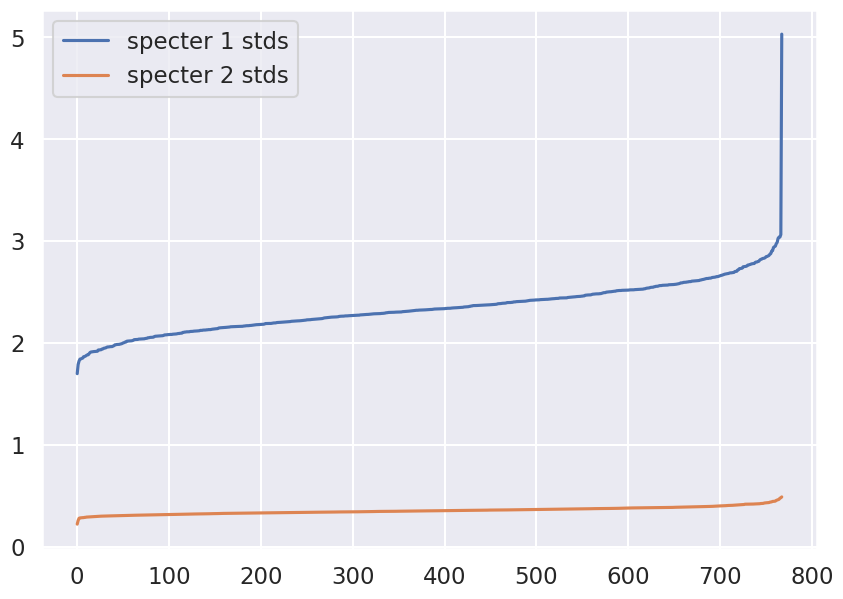

In [32]:
# print the mean and std of the actual values per dimension for both X1 and X2
plt.figure(figsize=(10, 7))
plt.plot(sorted(X1.mean(0)),label='specter 1 means')
plt.plot(sorted(X2.mean(0)), label='specter 2 means')
plt.legend()

plt.figure(figsize=(10, 7))
plt.plot(sorted(X1.std(0)), label='specter 1 stds')
plt.plot(sorted(X2.std(0)), label='specter 2 stds')
plt.legend()


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

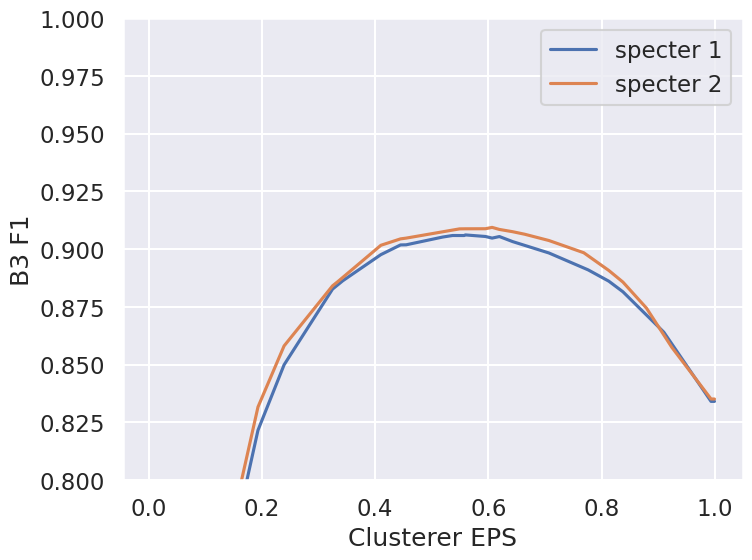

In [1]:
import os

os.environ["OMP_NUM_THREADS"] = "4"

import pickle
import numpy as np
from s2and.data import ANDData
from s2and.eval import cluster_eval
import matplotlib.pyplot as plt
import seaborn as sns
import json

CONFIG_LOCATION = os.path.abspath(os.path.join('..', "data", "path_config.json"))
with open(CONFIG_LOCATION) as _json_file:
    CONFIG = json.load(_json_file)

os.environ["OMP_NUM_THREADS"] = "8"

import numpy as np
import logging
import pickle

logger = logging.getLogger("s2and")

from tqdm import tqdm

os.environ["S2AND_CACHE"] = os.path.join(CONFIG["internal_data_dir"], ".feature_cache")
from random import shuffle
from s2and.data import ANDData
from s2and.featurizer import featurize, FeaturizationInfo
from s2and.model import PairwiseModeler, Clusterer, FastCluster
from s2and.eval import b3_precision_recall_fscore
from s2and.consts import FEATURIZER_VERSION
sns.set(context='talk')

import itertools
SPECTER_SUFFIX = ["_specter.pickle", "_specter2.pkl"]
SIGNATURES_SUFFIX = ["_signatures.json", "_signatures_with_s2aff.json"][0]

USE_CACHE = False
N_TRAIN_PAIRS_SIZE = 100000
N_VAL_TEST_SIZE = 10000
DATA_DIR = CONFIG["internal_data_dir"]

random_seed = 42
n_jobs = 4


# this is the prod 1.1 model
with open("../data/model_dump.pickle", "rb") as f:
    clusterer1 = pickle.load(f)["clusterer"]
    clusterer1.use_cache = False
    
with open("../data/model_dump_specter2.pickle", "rb") as f:
    clusterer2 = pickle.load(f)["clusterer"]
    clusterer2.use_cache = False

def extract_a_nice_trials_object(clusterer):
    trials = clusterer.hyperopt_trials_store.trials
    eps = []
    losses = []
    for trial in trials:
        eps.append(trial['misc']['vals']['choice'][0])
        losses.append(-trial['result']['loss'])
    # sort both by eps
    sort_indices = np.argsort(eps)
    eps = np.array(eps)[sort_indices]
    losses = np.array(losses)[sort_indices]
    return eps, losses

eps1, losses1 = extract_a_nice_trials_object(clusterer1)
eps2, losses2 = extract_a_nice_trials_object(clusterer2)

# plot both on same plot x: eps y: loss
plt.figure(figsize=(8, 6))
plt.plot(eps1, losses1, label='specter 1')
plt.plot(eps2, losses2, label='specter 2')
plt.ylim(0.8, 1)
plt.legend()
plt.ylabel('B3 F1')
plt.xlabel('Clusterer EPS')

with open('specter_version_iterative_experiment_results.pickle', 'rb') as f:
    s2and_comparison_results = pickle.load(f)

In [18]:
# assemble a dataframe for seaborn
import pandas as pd 
dataset_names = []
b3s = []
s2and_version = []
for dataset_name, (b3_f1s1, b3_f1s2) in s2and_comparison_results.items():

    # for i, j in list(zip(b3_f1s1, b3_f1s2)):
    #     if i != j:
    #         print(i, j, i-j)
    b3s_combined = b3_f1s1 + b3_f1s2
    b3s.extend(b3s_combined)
    s2and_vs = ['SPECTERv1'] * len(b3_f1s1) + ['SPECTERv2'] * len(b3_f1s2)
    s2and_version.extend(s2and_vs)
    dataset_names.extend([dataset_name] * len(b3s_combined))       
    # # plot a histogram of all the diffs
    # plt.figure(figsize=(14, 5))
    # plt.hist(np.array(b3_f1s1) - np.array(b3_f1s2), bins=100)
    # plt.xlabel('B3 F1 diff between clusterer1.predict_incremental and clusterer2.predict_incremental')
    # # log the x-axis
    # plt.yscale('log')
    # plt.title(dataset_name + ' : positive means S2AND_original is better, negative means S2AND_new is better')
    # plt.show()
    
df = pd.DataFrame({'S2AND Dataset': dataset_names, 'B3 F1': b3s, 'SPECTER Version': s2and_version})


Text(0.5, 1.0, 'Using SPECTERv2 instead of SPECTERv1 for S2AND in predict_iterative')

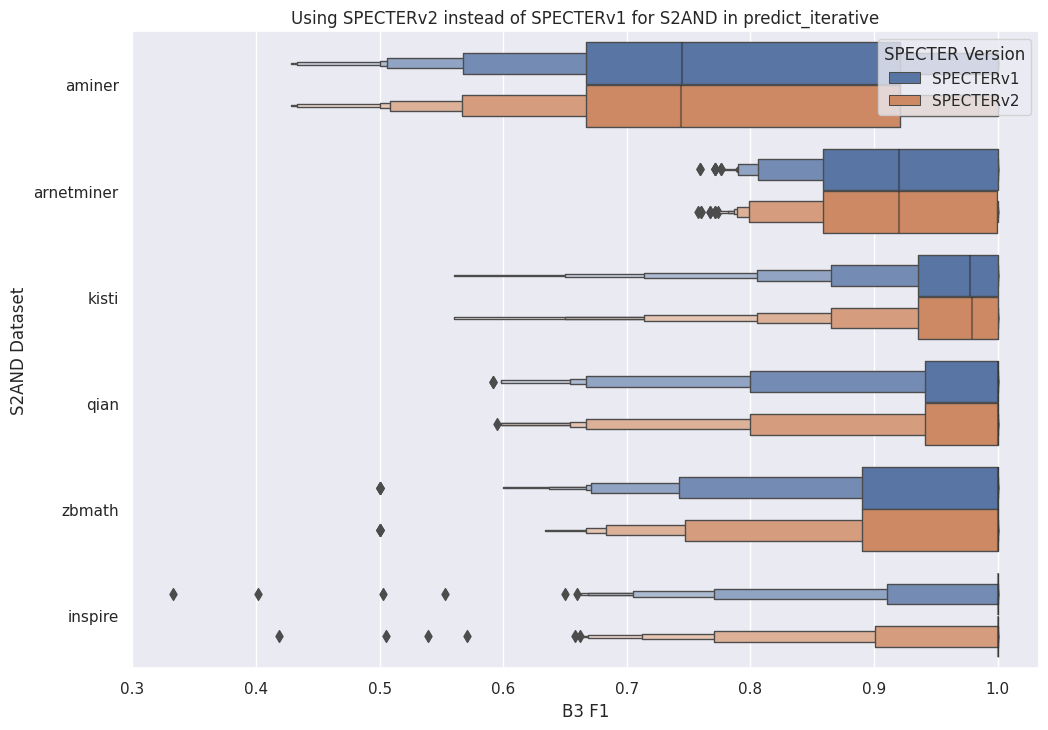

In [19]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxenplot(data=df, x="B3 F1", y="S2AND Dataset", hue="SPECTER Version")
plt.title('Using SPECTERv2 instead of SPECTERv1 for S2AND in predict_iterative')